In [10]:
%reload_ext autoreload
%autoreload 2
import sys
from dotenv import load_dotenv
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
load_dotenv()

ROOT = os.getenv("ROOT")
sys.path.append(ROOT)
assert ROOT is not None, "Please create a .env file and specify your ROOT path."
from src.data_loader import load_reviews
from src.processing import reviews_processing

In [4]:
df = load_reviews(category="All_beauty", frac=0.01)
df = reviews_processing(df=df, clean_text=False)
sub = df.rename(columns={"rating": "label", "review_input": "text"})[["label", "text"]]

[16:57:10] | INFO  | loaded 7015 rows                                                             ]8;id=82722;file:///Users/lucanyckees/Desktop/my-repos/recommendation_system/src/data_loader.py\data_loader.py]8;;\:]8;id=996397;file:///Users/lucanyckees/Desktop/my-repos/recommendation_system/src/data_loader.py#18\18]8;;\

In [7]:
def map_rating_to_sentiment(rating: float, min_rating: float = 1.0, max_rating: float = 5.0) -> str:
    threshold_rating = (max_rating + min_rating) / 2
    if rating < threshold_rating:
        return "negative"
    elif rating > threshold_rating:
        return "positive"
    else:
        return "neutral"

df["sentiment"] = df["rating"].apply(lambda x: map_rating_to_sentiment(rating=x))

Matplotlib is building the font cache; this may take a moment.


<Axes: >

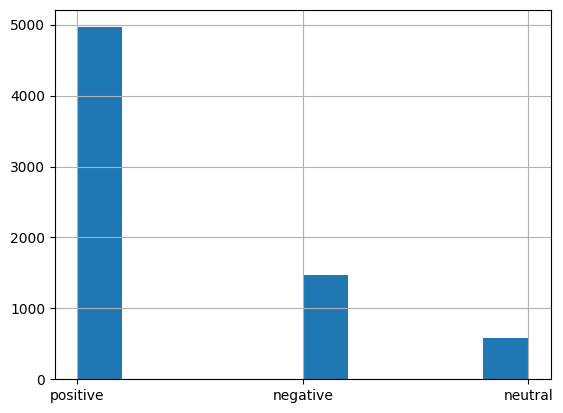

In [8]:
df["sentiment"].hist()

In [11]:
# Assume df is already loaded with the columns mentioned
# Extract features and target
X = df[['review_title', 'review']]
y = df['sentiment']

# Combine review_title and review into one text feature
X['combined_text'] = X['review_title'].fillna('') + ' ' + X['review'].fillna('')

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X['combined_text'], y_encoded, test_size=0.2, random_state=42)

# Vectorize text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for faster processing
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize XGBoost classifier
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)

# Train the classifier
xgb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = xgb.predict(X_test_tfidf)

/var/folders/h_/782hrx9d4w30ynjxd0zxc4lc0000gn/T/ipykernel_60609/713894472.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['combined_text'] = X['review_title'].fillna('') + ' ' + X['review'].fillna('')
/Users/lucanyckees/Desktop/my-repos/recommendation_system/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:08:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

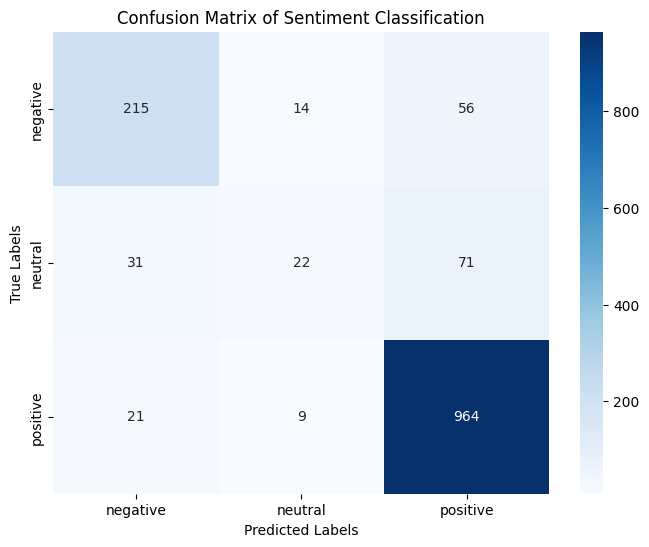

In [15]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Sentiment Classification")
plt.show()

In [16]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.81      0.75      0.78       285
     neutral       0.49      0.18      0.26       124
    positive       0.88      0.97      0.92       994

    accuracy                           0.86      1403
   macro avg       0.73      0.63      0.65      1403
weighted avg       0.83      0.86      0.84      1403



In [17]:
from sklearn.metrics import log_loss

# Get predicted probabilities for each class
y_pred_proba = xgb.predict_proba(X_test_tfidf)

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_proba)
print(f"Log Loss (Cross Entropy): {log_loss_value}")

Log Loss (Cross Entropy): 0.39912544479695994
